In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode

In [76]:
mode(x).mode

array([[0., 0.]])

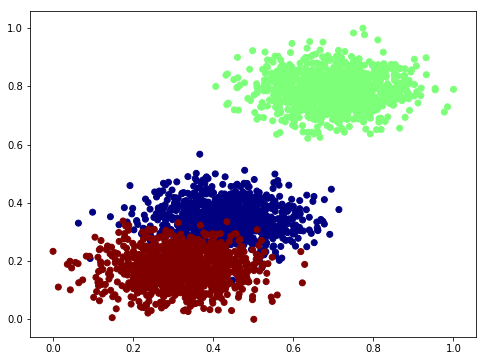

In [429]:
d = 2
k = 3
num = 1000

x = []
y = []
for i in np.arange(k):
    x.append(np.random.randn(num,d) + 8 * np.random.randn(1, d))
    y.append([i]*num)

y = np.hstack(y)
x = np.vstack(x)

x_max = np.max(x, axis = 0)
x_min = np.min(x, axis = 0)

x -= x_min
x /= (x_max - x_min)


plt.figure(figsize=(8,6))
plt.scatter(x[:,0], x[:,1], c = y, cmap = 'jet')


In [295]:
y.shape

(3000,)

In [361]:
def Gini(y):
    sum = 0
    for i in np.unique(y):
        sum += len(y[y==i])/len(y) * (1 - len(y[y==i])/len(y))    
    return sum

def IG(y, x_k, t, error_func):
    n = len(y)
    l = x_k<t
    return error_func(y) - (len(y[l])/n * error_func(y[l]) + (len(y[~l])/n * error_func(y[~l])))


In [448]:
def GetThreshold(x, y, error_func, num):
#     num = np.linspace(x.min(), x.max(), num = num)
    gain = []
    for k in range(x.shape[1]):
        row = []
        for i in np.linspace(x[:,k].min(), x[:,k].max(), num = num):
            row.append(IG(y, x[:,k], i, error_func))
        gain.append(np.array(row))
    gain = np.vstack(gain)
    gain[np.isnan(gain)] = -np.inf
    k, i = np.unravel_index(np.argmax(gain, axis = None), gain.shape)
    t = np.linspace(x[:,k].min(), x[:,k].max(), num = num)[i]
    return k, t, gain[k,i]
#gain[k, i]

In [386]:
def Mode(x, axis=0):
    return mode(x, axis).mode

### General Tree

In [513]:
class Tree:
    def __init__(self, x, y, error_func, agg_func, max_depth=5, gain_threshold=1e-2, num=50):
        # get split and save
        self.k, self.split_threshold, self.gain = GetThreshold(x,y, error_func, num)
#         ig = IG(y, x[:,self.k], self.split_threshold, error_func)
        left = x[:,self.k]<self.split_threshold
        if max_depth > 0 and self.gain > gain_threshold:
            self.left = Tree(x[left], y[left], error_func, agg_func, max_depth - 1, gain_threshold)
            self.right = Tree(x[~left], y[~left], error_func, agg_func, max_depth - 1, gain_threshold)
            self.leaf = False
        else:
            self.values = agg_func(y)
            self.leaf = True
        
    def predict(self, x):
        y_hat = np.ones(x.shape[0])
        if self.leaf:
            y_hat = self.values
        
        else:
            left = x[:,self.k] < self.split_threshold
            y_hat[left] = self.left.predict(x[left])
            y_hat[~left] = self.right.predict(x[~left])
        return y_hat
    
    def Interpret(self):
        if not self.leaf:
            left_ks, left_gains = self.left.Interpret()
            right_ks, right_gains =self.right.Interpret()
            print(left_gains)
            
            gains = np.hstack([np.array(self.gain), left_gains, right_gains])
            ks = np.hstack([np.array(self.k),left_ks, right_ks])
            
#             sort_ind = np.argsort(gains)[::-1]
#             print(self.k)
            
            return ks, gains
        
        else:
            return np.array([]), np.array([])
    
    def PtintInterpret(self, depth = 0, side = 'Root'):
        if not self.leaf:
            print('{}{}'.format('  '*depth, side))
            print('{}k: {}'.format('  '*(depth+1)+' ', self.k))
            print('{}gain: {}'.format('  '*(depth+1)+ ' ', self.gain))
            
            self.left.PtintInterpret(depth+1, 'Left')
            self.right.PtintInterpret(depth+1, 'Right')
            
            

In [514]:
tree = Tree(x, y, error_func=Gini, agg_func=Mode, max_depth=5, gain_threshold=0.001)

In [515]:
y_hat = tree.predict(x)

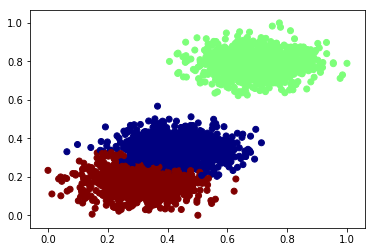

In [516]:
plt.scatter(x[:,0], x[:,1], c = y_hat , cmap='jet')

In [517]:
tree.Interpret()

[]
[]
[0.00244378]
[]
[]
[0.01272445]
[0.00739022 0.00244378 0.10650888]
[]
[]
[0.05395944]
[]
[0.11379393]
[0.07531247 0.05395944 0.01575897]
[0.02919409 0.00739022 0.00244378 0.10650888 0.16816428 0.01272445
 0.03169211]
[0.34873839 0.02919409 0.00739022 0.00244378 0.10650888 0.16816428
 0.01272445 0.03169211 0.02170861 0.07531247 0.05395944 0.01575897
 0.0044003  0.11379393]


(array([1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.]),
 array([0.33333333, 0.34873839, 0.02919409, 0.00739022, 0.00244378,
        0.10650888, 0.16816428, 0.01272445, 0.03169211, 0.02170861,
        0.07531247, 0.05395944, 0.01575897, 0.0044003 , 0.11379393]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3506: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


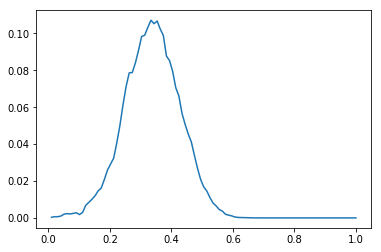

In [518]:
ig = []
t = np.linspace(0, 1, num = 100)
for i in t:
    ig.append(IG(y, x[:,0], i, np.var))

plt.plot(t, ig)

In [392]:
x.shape

(3000, 2)

In [393]:
x = np.random.rand(1000,1) * 5 - 2.5
y = x ** 5 - 8* x ** 3 + 10 * x + 6 + np.random.randn(x.shape[0],1)

In [394]:
x.shape

(1000, 1)

In [395]:
y = y.reshape(-1,)

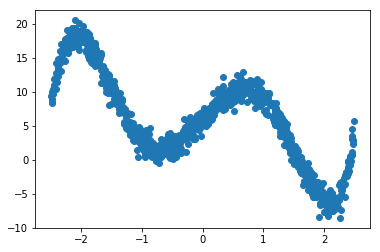

In [396]:
plt.scatter(x,y)

In [397]:
y[[1,2,3,4]]

array([2.88008093, 9.81367006, 5.90662133, 0.50418042])

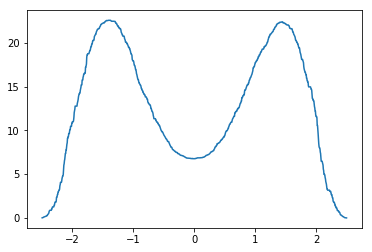

In [398]:
ig = []
t = np.linspace(-2.5, 2.5, num = 1000)
for i in t:
    ig.append(IG(y, x[:,0], i, np.var))

plt.plot(t, ig)

In [404]:
tree1 = Tree(x, y , np.var, np.mean, 10, 0.001)

In [405]:
y_hat = tree1.predict(x)

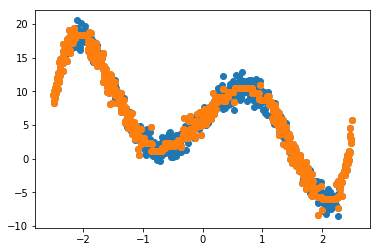

In [406]:
plt.scatter(x,y)
plt.scatter(x, y_hat)
